In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns
import time

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
s0 = pd.read_csv("./data/sale_to_customer_rl_10_price_change_data.csv", usecols = ['d_index_1', 'd_index_2', 'name',
		'cusip', 'state', 'coupon', 'maturity', 'yield', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'tradedate_2', 'price', 'dprice', 'holdtime'])
#d = extract.get_data("./data/TMC_020617.csv")
#d = extract.clean_data(d)

In [4]:
s0.head()

,dprice,holdtime,d_index_1,d_index_2,tradedate_2,cusip,price,yield,tradedate,name,state,coupon,maturity,issuetype,issuesource,rtg
0,0.476,1.0,0,2676,3.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
1,0.488,2.0,0,2677,4.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
2,3.239,8.0,0,8287,10.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
3,3.089,9.0,0,9511,11.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
4,3.476,9.0,0,9512,11.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6


In [5]:
#print s0[(s0.cusip == '45471AKG6')&(s0.tradedate == 2.0)]

In [6]:
d_index_1 = s0.pop('d_index_1')
d_index_2 = s0.pop('d_index_2')

In [7]:
s_name_features = extract.build_name_features(s0, num_general_words = 50, num_long_words = 100, long_word_length = 5)
s_state_features = extract.build_state_features(s0, num_states = None)
s_other_features = extract.build_other_text_features(s0, tradetype=False)
s = pd.concat([s0.drop(['state', 'name', 'issuetype', 'issuesource', 'cusip', 'price'], axis = 1), s_state_features, s_other_features, s_name_features], axis = 1)
s = s.dropna()
s = s[s.holdtime < 7] #pick out only data with holdtime < max days

In [8]:
s.head()

,dprice,holdtime,tradedate_2,yield,tradedate,coupon,maturity,rtg,Alabama,Alaska,...,grove,mooresville,antonio,shreveport,hlth,pension,transprtn,turnpike,hartford,nthrnuniv
0,0.476,1.0,3.0,4.037,2.0,4.0,6692.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.488,2.0,4.0,4.037,2.0,4.0,6692.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0.573,1.0,3.0,4.045,2.0,4.0,6692.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0.585,2.0,4.0,4.045,2.0,4.0,6692.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0.012,1.0,4.0,4.000,3.0,4.0,6691.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0


### Try a Random Forest Regressor

In [9]:
dprice = s.pop('dprice')

In [10]:
#s_train, s_test, dp_train, dp_test = train_test_split(s, dprice, test_size=0.20, random_state=180)
s_train = s[(s.tradedate < 20)&(s.tradedate_2 < 21)]
dp_train = dprice[(s.tradedate < 20)&(s.tradedate_2 < 21)]
s_test = s[s.tradedate >= 21]
dp_test = dprice[s.tradedate >= 21]

In [11]:
s_train.pop('tradedate_2')
s_test.pop('tradedate_2')

66        24.0
69        24.0
72        30.0
74        31.0
157       25.0
158       25.0
159       25.0
160       25.0
161       25.0
162       25.0
214       24.0
215       24.0
222       29.0
223       30.0
224       30.0
291       26.0
293       32.0
337       26.0
341       29.0
342       31.0
343       31.0
344       31.0
345       31.0
650       29.0
651       29.0
653       31.0
654       31.0
1489      24.0
1490      26.0
1491      26.0
          ... 
212164    29.0
212166    31.0
212167    29.0
212168    31.0
212169    31.0
212171    29.0
212172    29.0
212173    30.0
212174    31.0
212175    31.0
212176    31.0
212177    31.0
212178    29.0
212179    29.0
212180    29.0
212181    29.0
212182    29.0
212183    30.0
212184    30.0
212185    26.0
212187    32.0
212188    32.0
212189    32.0
212190    29.0
212191    30.0
212192    31.0
212193    31.0
212194    31.0
212195    31.0
212196    31.0
Name: tradedate_2, dtype: float64

### Want to optimize the max_depth and n_estimators parameters of the regressor with respect to the percentage of winning predictions that are actually winners. To do this, we construct a custom scorer function

In [12]:
def scorer(clf, X_test, y_test):
    #we want to maximize f1 score value = 2*(precision*recall)/(precision + recall)
    y_predict = clf.predict(X_test)
    recall = float(np.sum(y_predict[y_test > 0] > 0))/np.sum(y_test > 0) #percent of true dprice>0 cases model can predict
    precision = float(np.sum(y_test[y_predict > 0] > 0))/np.sum(y_predict > 0) #percent of increases predicted are actually correct
    return 2*precision*recall/(precision + recall)

In [12]:
#parameters = {'max_depth':[10, 15, 20, 25], 'n_estimators':[50, 100], 'criterion':['mse']}
#rfr = RandomForestRegressor()
#clf = GridSearchCV(rfr, param_grid = parameters, scoring = scorer)
clf = RandomForestRegressor(max_depth = None, n_estimators = 200, max_features = None, random_state = 27)

In [13]:
t0 = time.time()
clf.fit(s_train, dp_train)
print time.time() - t0

133.505023003


In [14]:
#clf.cv_results_
#estimator = clf.best_estimator_
#clf.best_params_

In [15]:
#dp_predict = estimator.predict(s_test)
dp_predict = clf.predict(s_test)

In [16]:
I1 = dp_test > 0
np.sum(I1)
#scorer(estimator, s_test, dp_test)

8104

### below: of the actual test cases where price increased, which fraction were predicted by the model to be an increase?

In [32]:
float(np.sum(dp_predict[I1] > 0))/np.sum(I1)

0.25061697926949655

In [33]:
I2 = (dp_test > 0) & (dp_predict > 0)
np.sum(I2)

2031

### below: percentage of samples that were predicted by model to be increase and were actually an increase.

In [34]:
precision_ratio = float(np.sum(I2))/np.sum(dp_predict > 0)
precision_ratio

0.6111947035811014

### below: percentage of total predictions correct

In [20]:
float(np.sum((dp_predict>0) == (dp_test>0)))/dp_test.size

0.5614766299493897

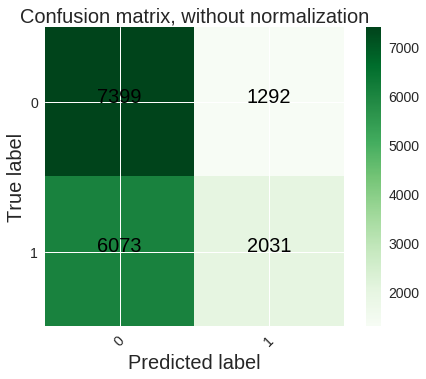

In [21]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict>0).astype(np.int))
fig = visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], fontsize = 20, normalize = False, title='Confusion matrix, without normalization', cmap = plt.cm.Greens)
plt.show()


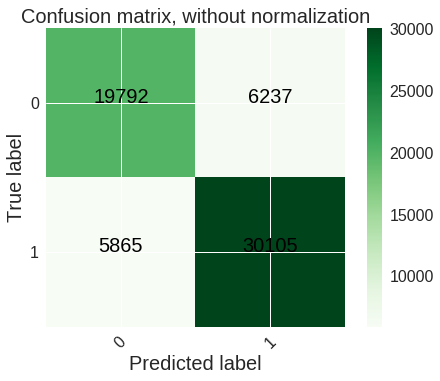

In [22]:
cnf_matrix = confusion_matrix((dp_train>0).astype(np.int), (clf.predict(s_train)>0).astype(np.int))
fig = visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], fontsize = 20, tick_fontsize = 16, cmap = plt.cm.Greens, title='Confusion matrix, without normalization')
plt.show()

### For correctly predicted winners, what are typical values of dprice? Also plot distribution of dprice_test when winner is predicted but it's actually a loser on same axes.

In [127]:
#I2 = (dp_test > 0) & (dp_predict > 0)
#dp_slice_winner = dp_test[I2]
#dp_slice_loser = dp_test[(dp_test < 0) & (dp_predict > 0)]
#print dp_slice_loser.min(), dp_slice_loser.max(), dp_slice_loser.mean()
#ax1 = sns.distplot(dp_slice_loser.values)
#ax2 = sns.distplot(dp_slice_winner.values)
#ax2.set_title('Distribution of dprice')
#sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
#plt.show()

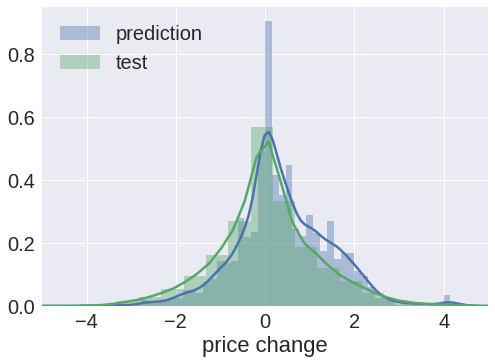

0.39635690641 1.03681654591
-0.050765525454 1.65736986126


In [31]:
dp_predict_winner_density = dp_test[dp_predict > 0]
ax = sns.distplot(dp_predict_winner_density, label='prediction')
ax2 = sns.distplot(dp_test, label='test')
ax.set(xlim = (-5,5))
ax2.set(xlim = (-5,5))
plt.legend(loc='upper left')
ax.set_xlabel('price change', fontsize = 22)
#ax.set_title('Distribution of dprice[d_predict > 0]')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
plt.show()
print dp_predict_winner_density.mean(), dp_predict_winner_density.std()
print dp_test.mean(), dp_test.std()

In [41]:
print dp_test.mean(), dp_test.std()
print dp_train.mean(), dp_train.std()

-0.050765525454 1.65736986126
0.251807142051 1.05489608799


In [24]:
s_test_index = s_test.index
#winners = s0.loc[s_test[(dp_predict > 0) & (dp_test > 0)].index.values, :]
winners = s0.loc[s_test[dp_predict > 0].index.values, :]
winners.loc[winners.state == 'California', :].dprice.mean()
#winners.head()

0.25145600858369055

In [25]:
#clf.best_estimator_.feature_importances_[:20]
clf.feature_importances_[:20]

array([  8.76567804e-02,   4.04685922e-01,   1.19828357e-01,
         4.21158373e-02,   1.00554219e-01,   2.46737854e-02,
         1.39091564e-03,   5.56177389e-06,   2.73434361e-04,
         2.90833103e-06,   3.08182110e-03,   1.72966827e-04,
         1.95167356e-03,   5.79217261e-05,   9.93532320e-05,
         1.69349350e-03,   6.04366298e-04,   4.33806180e-05,
         1.43454703e-04,   9.00031739e-06])

In [26]:
#important_features_indices = np.where(clf.best_estimator_.feature_importances_ > 0.01)
#ordered_indices = sorted(range(s.shape[1]), key=clf.best_estimator_.feature_importances_.__getitem__)
important_features_indices = np.where(clf.feature_importances_ > 0.001)
ordered_indices = sorted(range(s_train.shape[1]), key=clf.feature_importances_.__getitem__)
ordered_indices.reverse()
ordered_indices[:20]

[1,
 2,
 4,
 0,
 3,
 5,
 36,
 263,
 265,
 66,
 305,
 75,
 342,
 371,
 77,
 74,
 290,
 65,
 374,
 10]

In [30]:
for w in list(s_train.columns[ordered_indices[:20]]):
    print w.upper()

YIELD
TRADEDATE
MATURITY
HOLDTIME
COUPON
RTG
NEW JERSEY
CMNTYS
STWD
ISSUE SOURCE: APPROPRIATIONS
REF
ISSUE SOURCE: GOVT. FD./GRANT REV.
SWR
ST
ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.
ISSUE SOURCE: GENERAL FUND
EL
ISSUE SOURCE: AD VALOREM PROPERTY TAX
PURP
CALIFORNIA


In [181]:
#clf.best_estimator_.feature_importances_[ordered_indices[:20]]
clf.feature_importances_[ordered_indices[:20]]

array([ 0.40468592,  0.11982836,  0.10055422,  0.08765678,  0.04211584,
        0.02467379,  0.01737354,  0.01680968,  0.01568277,  0.01436234,
        0.00829194,  0.00507605,  0.004854  ,  0.00463271,  0.00425308,
        0.00360667,  0.00337317,  0.00311807,  0.00309633,  0.00308182])

In [35]:
clf_dec = DecisionTreeRegressor(max_features = None, random_state = 29)
t0 = time.time()
clf_dec.fit(s_train, dp_train)
print time.time() - t0

1.15910696983


In [36]:
dp_predict_dec = clf_dec.predict(s_test)

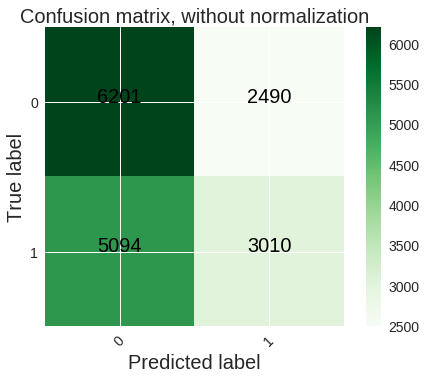

In [37]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict_dec>0).astype(np.int))
fig = visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], fontsize = 20, normalize = False, title='Confusion matrix, without normalization', cmap = plt.cm.Greens)
plt.show()

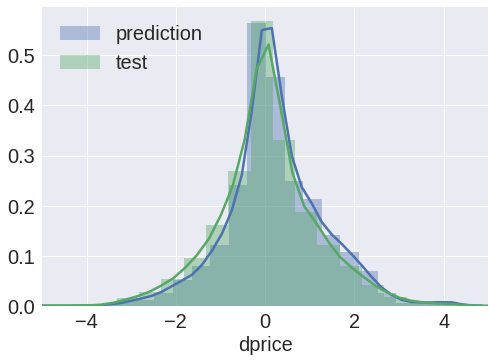

0.196814727273 1.24373233706


In [38]:
dp_predict_dec_winner_density = dp_test[dp_predict_dec > 0]
ax = sns.distplot(dp_predict_dec_winner_density, label='prediction')
ax.set_xlabel('price change', fontsize = 20)
ax2 = sns.distplot(dp_test, label='test')
ax.set(xlim = (-5,5))
ax2.set(xlim = (-5,5))
plt.legend(loc='upper left')
#ax.set_title('Distribution of dprice[d_predict > 0]')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
plt.show()
print dp_predict_dec_winner_density.mean(), dp_predict_dec_winner_density.std()

In [39]:
tree.export_graphviz(clf_dec, 'dprice_decision_tree_2.dot', max_depth = 4, filled = True, feature_names = list(s_test.columns))

### To convert to .png, in the terminal type "dot -Tpng dprice_decision_tree_0.dot -o dprice_decision_tree_0.png"

### insert random feature into training set and see how it ranks feature importances

In [192]:
s_train_aug = s_train.copy()
s_train_aug['random'] = np.random.rand(s_train_aug.shape[0])

In [209]:
clf_ran = RandomForestRegressor(max_depth = None, n_estimators = 200, max_features = None, random_state = 27)

In [210]:
clf_ran.fit(s_train_aug.values, dp_train.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=27,
           verbose=0, warm_start=False)

In [213]:
#s_test_aug = s_test.copy()
#s_test_aug['random'] = np.random.rand(s_test_aug.shape[0])
#s_test_aug.shape[1]
#s_train_aug.shape[1]
dp_predict_ran = clf_ran.predict(s_test_aug.values)
#s_test_aug.head()

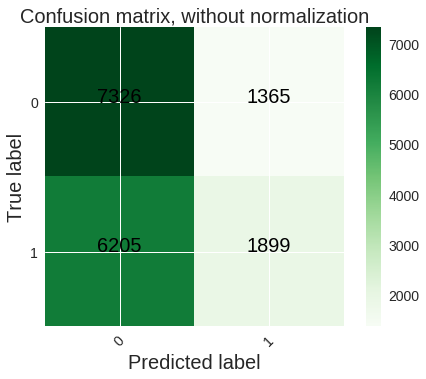

In [214]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict_ran>0).astype(np.int))
fig = visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], fontsize = 20, normalize = False, title='Confusion matrix, without normalization', cmap = plt.cm.Greens)
plt.show()

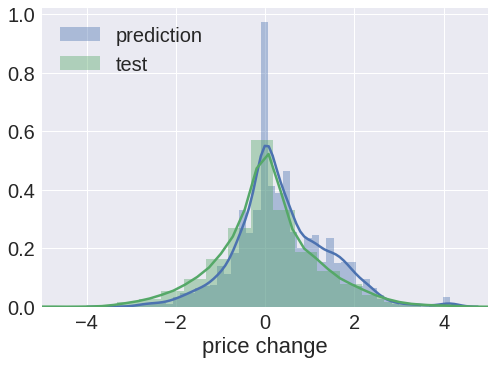

0.353292585784 1.03285418386
-0.050765525454 1.65736986126


In [215]:
dp_predict_ran_winner_density = dp_test[dp_predict_ran > 0]
ax = sns.distplot(dp_predict_ran_winner_density, label='prediction')
ax2 = sns.distplot(dp_test, label='test')
ax.set(xlim = (-5,5))
ax2.set(xlim = (-5,5))
plt.legend(loc='upper left')
ax.set_xlabel('price change', fontsize = 22)
#ax.set_title('Distribution of dprice[d_predict > 0]')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
plt.show()
print dp_predict_ran_winner_density.mean(), dp_predict_ran_winner_density.std()
print dp_test.mean(), dp_test.std()

In [216]:
clf_ran.feature_importances_[:20]

array([  6.55977864e-02,   3.06307675e-01,   9.00548327e-02,
         3.10057222e-02,   7.56366446e-02,   1.80782033e-02,
         1.08552124e-03,   3.22232193e-06,   2.01686844e-04,
         2.71167766e-06,   2.25751868e-03,   1.11136295e-04,
         1.39971542e-03,   5.40905390e-05,   7.24292442e-05,
         1.25784337e-03,   4.17269566e-04,   2.40778089e-05,
         1.01531956e-04,   6.20000809e-06])

In [218]:
#important_features_indices = np.where(clf_ran.feature_importances_ > 0.001)
ordered_indices_aug = sorted(range(s_train_aug.shape[1]), key=clf_ran.feature_importances_.__getitem__)
ordered_indices_aug.reverse()
ordered_indices_aug[:100]

[1,
 398,
 2,
 4,
 0,
 3,
 5,
 36,
 265,
 263,
 66,
 305,
 75,
 342,
 371,
 77,
 74,
 290,
 10,
 65,
 374,
 310,
 273,
 61,
 20,
 94,
 42,
 60,
 73,
 44,
 38,
 69,
 262,
 314,
 269,
 259,
 325,
 50,
 12,
 76,
 57,
 331,
 15,
 260,
 41,
 6,
 88,
 54,
 330,
 79,
 27,
 363,
 332,
 283,
 107,
 59,
 327,
 392,
 358,
 276,
 318,
 380,
 299,
 349,
 106,
 47,
 319,
 272,
 360,
 306,
 32,
 71,
 291,
 394,
 28,
 347,
 393,
 92,
 391,
 293,
 356,
 281,
 23,
 81,
 16,
 34,
 346,
 317,
 282,
 396,
 386,
 329,
 365,
 91,
 321,
 377,
 25,
 309,
 277,
 98]

In [219]:
for w in list(s_train_aug.columns[ordered_indices_aug[:20]]):
    print w.upper()

YIELD
RANDOM
TRADEDATE
MATURITY
HOLDTIME
COUPON
RTG
NEW JERSEY
STWD
CMNTYS
ISSUE SOURCE: APPROPRIATIONS
REF
ISSUE SOURCE: GOVT. FD./GRANT REV.
SWR
ST
ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.
ISSUE SOURCE: GENERAL FUND
EL
CALIFORNIA
ISSUE SOURCE: AD VALOREM PROPERTY TAX


In [220]:
clf_ran.feature_importances_[ordered_indices_aug[:20]]

array([ 0.30630768,  0.25180724,  0.09005483,  0.07563664,  0.06559779,
        0.03100572,  0.0180782 ,  0.01272522,  0.01218883,  0.01168208,
        0.01048156,  0.00606621,  0.00372602,  0.00360408,  0.00341854,
        0.00305551,  0.00265036,  0.00249493,  0.00225752,  0.00223888])